## Method 2: integrate the word2vect to the first method

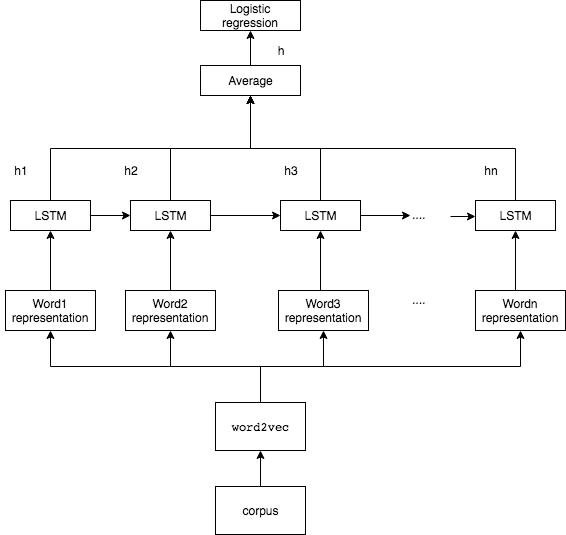

In [1]:
from IPython.display import Image
Image("LSTM_Wordembedding.png")

In [2]:
from __future__ import print_function
import six.moves.cPickle as pickle

from collections import OrderedDict
import sys
import time
import numpy

import os
import theano
from theano import config
import theano.tensor as tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import imdb
import Wemb_gensim

import pickle as pkl
import gensim

In [3]:
datasets = {'imdb': (imdb.load_data, imdb.prepare_data)}
SEED = 123
numpy.random.seed(SEED)

In [4]:
def adadelta(lr, tparams, grads, x, mask, y, cost):
    """
    An adaptive learning rate optimizer

    Parameters
    ----------
    lr : Theano SharedVariable
        Initial learning rate
    tpramas: Theano SharedVariable
        Model parameters
    grads: Theano variable
        Gradients of cost w.r.t to parameres
    x: Theano variable
        Model inputs
    mask: Theano variable
        Sequence mask
    y: Theano variable
        Targets
    cost: Theano variable
        Objective fucntion to minimize

    Notes
    -----
    For more information, see [ADADELTA]_.

    .. [ADADELTA] Matthew D. Zeiler, *ADADELTA: An Adaptive Learning
       Rate Method*, arXiv:1212.5701.
    """

    zipped_grads = [theano.shared(p.get_value() * numpy_floatX(0.),
                                  name='%s_grad' % k)
                    for k, p in tparams.items()]
    running_up2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                 name='%s_rup2' % k)
                   for k, p in tparams.items()]
    running_grads2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                    name='%s_rgrad2' % k)
                      for k, p in tparams.items()]

    zgup = [(zg, g) for zg, g in zip(zipped_grads, grads)]
    rg2up = [(rg2, 0.95 * rg2 + 0.05 * (g ** 2))
             for rg2, g in zip(running_grads2, grads)]

    f_grad_shared = theano.function([x, mask, y], cost, updates=zgup + rg2up,
                                    name='adadelta_f_grad_shared')

    updir = [-tensor.sqrt(ru2 + 1e-6) / tensor.sqrt(rg2 + 1e-6) * zg
             for zg, ru2, rg2 in zip(zipped_grads,
                                     running_up2,
                                     running_grads2)]
    ru2up = [(ru2, 0.95 * ru2 + 0.05 * (ud ** 2))
             for ru2, ud in zip(running_up2, updir)]
    param_up = [(p, p + ud) for p, ud in zip(tparams.values(), updir)]

    f_update = theano.function([lr], [], updates=ru2up + param_up,
                               on_unused_input='ignore',
                               name='adadelta_f_update')

    return f_grad_shared, f_update

In [5]:
def ortho_weight(ndim):
    W = numpy.random.randn(ndim, ndim)
    u, s, v = numpy.linalg.svd(W)
    return u.astype(config.floatX)

In [6]:
def _p(pp, name):
    return '%s_%s' % (pp, name)

In [7]:
# Initialize the parameters of lstm layer
def param_init_lstm(options, params, prefix='lstm'):
    """
    Init the LSTM parameter:

    :see: init_params
    """
    W = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'W')] = W # _p is a function to concate prefix and W --> lstm_W
    U = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'U')] = U
    b = numpy.zeros((4 * options['dim_proj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [8]:
# state_below is passed in the emb --> the weights in the first layer ? why not X
# because emb is the embedding of words which represents words
def lstm_layer(tparams, state_below, options, prefix='lstm', mask=None):
    nsteps = state_below.shape[0] # time steps namely, the number of words in a sentence
    if state_below.ndim == 3:
        n_samples = state_below.shape[1] # the number of sentences in a minibatch
    else:
        n_samples = 1 # in the case of no minibach applied, then train with one sentence at a time

    assert mask is not None # sequence mask must be provided

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n * dim:(n + 1) * dim]
        return _x[:, n * dim:(n + 1) * dim]

    # m_: mask, x_: state_below which is emb * lstm_W + lstm_b
    def _step(m_, x_, h_, c_):
        preact = tensor.dot(h_, tparams[_p(prefix, 'U')]) # lstm_U*h_t-1
        preact += x_ # Wemb * lstm_W + lstm_b + lstm_U*h_t-1

        i = tensor.nnet.sigmoid(_slice(preact, 0, options['dim_proj']))
        f = tensor.nnet.sigmoid(_slice(preact, 1, options['dim_proj']))
        o = tensor.nnet.sigmoid(_slice(preact, 2, options['dim_proj']))
        c = tensor.tanh(_slice(preact, 3, options['dim_proj']))

        c = f * c_ + i * c # c_ means previous state refer to s[t]= f*s[t-1] + i*s[t]
        c = m_[:, None] * c + (1. - m_)[:, None] * c_ # c is of shape (minibatch maxlen, number of sentences
                                                    # in a minibatch, word embbdeding size) = (98, 16, 4)
        # c = theano.printing.Print('c')(c)

        h = o * tensor.tanh(c)
        h = m_[:, None] * h + (1. - m_)[:, None] * h_

        return h, c

    # emb * lstm_W + lstm_b
    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'W')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    # scan function, sequence is the input x, nonsequence is ussually not iterated such as w and b
    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[tensor.alloc(numpy_floatX(0.),
                                                           n_samples,
                                                           dim_proj),
                                              tensor.alloc(numpy_floatX(0.),
                                                           n_samples,
                                                           dim_proj)],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps) # repeat as the number of words in a sentence
    return rval[0] # rval = h which is of shape (n_samples, dim_proj)

In [9]:
def gru_layer(tparams, state_below, options, prefix='gru', mask=None):
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    assert mask is not None

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n * dim:(n + 1) * dim]
        return _x[:, n * dim:(n + 1) * dim]
    
    def x_seperate(_x, dim):
        if _x.ndim == 3:
            return _x[:, :, 0: 2 * dim], _x[:, :, 2 * dim:]
        return _x[:, 0: 2 * dim], _x[:, 2 * dim:]

    def _step(m_, x_, h_):
        _x12, _x3 = x_seperate(x_, model_options['dim_proj'])

        preact = tensor.dot(h_, tparams[_p(prefix, 'U')])
        preact += _x12

        m = tensor.nnet.sigmoid(preact)
        r = _slice(m, 0, model_options['dim_proj'])
        u = _slice(m, 1, model_options['dim_proj'])

        _h = tensor.tanh(_x3 + tensor.dot(r * h_, tparams[_p(prefix, 'W_hh')]))
        h = u * h_ + (1.0 - u) * _h

        h = m_[:, None] * h + (1. - m_)[:, None] * h_

        return h

    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'W')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    initial_hidden_vector = tensor.alloc(numpy_floatX(0.), n_samples, dim_proj)

    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[initial_hidden_vector],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps)
    return rval[0]

In [10]:
# Initialize the parameters of gru layer
def param_init_gru(options, params, prefix='gru'):
    """
    Init the GRU parameter:

    :see: init_params
    """
    W = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'W')] = W
        
    U = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'U')] = U

    W_hh = ortho_weight(options['dim_proj'])
    params[_p(prefix, 'W_hh')] = W_hh

    b = numpy.zeros((3 * options['dim_proj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [11]:
def vanilla_layer(tparams, state_below, options, prefix='vanilla', mask=None):
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    assert mask is not None

    def _step(m_, x_, h_):
        a = x_ + tensor.dot(h_, tparams[_p(prefix, 'W')])
        h = tensor.tanh(a)
        h = m_[:, None] * h + (1. - m_)[:, None] * h_
        return h

    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'U')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    initial_hidden_vector = tensor.alloc(numpy_floatX(0.), n_samples, dim_proj)

    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[initial_hidden_vector],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps)
    return rval[0]

In [14]:
def param_init_vanilla(options, params, prefix='vanilla'):
    """
    Init the vanilla RNN parameter:

    :see: init_params
    """
    ndim = options['dim_proj']
    W_bound = numpy.sqrt(6. / (ndim + ndim))

    U = numpy.asarray(numpy.random.uniform(low=-W_bound, high=W_bound, size=(ndim, ndim)))
    params[_p(prefix, 'U')] = U.astype(config.floatX)
    
    W = numpy.asarray(numpy.random.uniform(low=-W_bound, high=W_bound, size=(ndim, ndim)))
    params[_p(prefix, 'W')] = W.astype(config.floatX)

    b = numpy.zeros(options['dim_proj'],)
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [15]:
# ff: Feed Forward (normal neural net), only useful to put after lstm
#     before the classifier.
layers = {'lstm': (param_init_lstm, lstm_layer), \
         'gru': (param_init_gru, gru_layer), \
         'vanilla': (param_init_vanilla, vanilla_layer)}

def get_layer(name):
    fns = layers[name]
    return fns

In [16]:
def init_params(options):
    """
    Global (not LSTM) parameters. For the embeding and the classifier.
    """
    params = OrderedDict()

    # embedding layer
    if(options['gensim_Wemb']):
        f = open('/Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/gensim_imdb_Wemb.pkl', 'rb')
        Wemb = pkl.load(f)
        f.close()

        params['Wemb'] = (Wemb[:options['n_words']]).astype(config.floatX)
        # print(params['Wemb'].shape)
        assert params['Wemb'].shape[0] == options['n_words']
        assert params['Wemb'].shape[1] == options['dim_proj']
    else:
        print('wemb random initialization')
        randn = numpy.random.rand(options['n_words'],
                                  options['dim_proj']) # n_words = vocabulary size, dim_proj = word embedding size
        params['Wemb'] = (0.01 * randn).astype(config.floatX)

    # lstm layer
    params = get_layer(options['encoder'])[0](options, params, prefix=options['encoder'])

    # classifier
    params['U'] = 0.01 * numpy.random.randn(options['dim_proj'],
                                            options['ydim']).astype(config.floatX)
    params['b'] = numpy.zeros((options['ydim'],)).astype(config.floatX)

    return params

In [17]:
def init_tparams(params):
    tparams = OrderedDict()
    for kk, pp in params.items():
        tparams[kk] = theano.shared(params[kk], name=kk)
    return tparams

In [18]:
# state_before is proj namely hidden state
def dropout_layer(state_before, use_noise, trng):
    proj = tensor.switch(use_noise,
                         (state_before *
                          trng.binomial(state_before.shape,
                                        p=0.5, n=1,
                                        dtype=state_before.dtype)),
                         state_before * 0.5)
    return proj

In [19]:
def numpy_floatX(data):
    return numpy.asarray(data, dtype=config.floatX)

In [20]:
def build_model(tparams, options):
    trng = RandomStreams(SEED)

    # Used for dropout.
    use_noise = theano.shared(numpy_floatX(0.)) # --> [0], thus this line of code is the same as use_noise=[0]

    x = tensor.matrix('x', dtype='int64') # x is a sentence with each word form a row?
    mask = tensor.matrix('mask', dtype=config.floatX) # sequence mask
    y = tensor.vector('y', dtype='int64')

    n_timesteps = x.shape[0] # number of words per sentence
    n_samples = x.shape[1] # number of sentences in a minibatch

    # x.flatten() --> number_timesteps * n_samples
    emb = tparams['Wemb'][x.flatten()].reshape([n_timesteps,
                                                n_samples,
                                                options['dim_proj']]) # each word in the sentence
                                                                      # get different weights

    # call get_layer(options['encoder'])[1] --> lstm_layer --> lstm_layer(tparams,...,)
    # here emb is used to initialize states_below in lstm_layer function
    proj = get_layer(options['encoder'])[1](tparams, emb, options,
                                            prefix=options['encoder'],
                                            mask=mask)

    projshape = theano.printing.Print('proj')(proj.shape)
    # mean over word hidden representations in a sentence, proj is of shape(n_samples, dim_proj)
    if options['encoder'] == 'lstm' or options['encoder'] == 'gru':
        proj = (proj * mask[:, :, None]).sum(axis=0) # add up the hidden representations of all words in a sentence
        proj = proj / mask.sum(axis=0)[:, None] # mask.sum(axis=0) is the length of sentence without padding
    if options['use_dropout']:
        proj = dropout_layer(proj, use_noise, trng)

    # last layer
    pred = tensor.nnet.softmax(tensor.dot(proj, tparams['U']) + tparams['b'])
    # pred is the probability of a sentence belonging to a class. It is of shape (n_samples, class)

    f_pred_prob = theano.function([x, mask], pred, name='f_pred_prob')
    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    if pred.dtype == 'float16':
        off = 1e-6

    # get the probability of the right class and calculate its negative log. --> negative log likelihood
    cost = -tensor.log(pred[tensor.arange(n_samples), y] + off).mean()

    return use_noise, x, mask, y, f_pred_prob, f_pred, cost

In [21]:
def get_minibatches_idx(n, minibatch_size, shuffle=False):
    """
    Used to shuffle the dataset at each iteration.
    """

    idx_list = numpy.arange(n, dtype="int32")

    if shuffle:
        numpy.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

In [22]:
def unzip(zipped):
    """
    When we pickle the model. Needed for the GPU stuff.
    """
    new_params = OrderedDict()
    for kk, vv in zipped.items():
        new_params[kk] = vv.get_value()
    return new_params

In [23]:
def zipp(params, tparams):
    """
    When we reload the model. Needed for the GPU stuff.
    """
    for kk, vv in params.items():
        tparams[kk].set_value(vv)

In [24]:
def pred_error(f_pred, prepare_data, data, iterator, verbose=False):
    """
    Just compute the error
    f_pred: Theano fct computing the prediction
    prepare_data: usual prepare_data for that dataset.
    """
    valid_err = 0
    for _, valid_index in iterator:
        x, mask, y = prepare_data([data[0][t] for t in valid_index],
                                  numpy.array(data[1])[valid_index],
                                  maxlen=None)
        preds = f_pred(x, mask)
        targets = numpy.array(data[1])[valid_index]
        valid_err += (preds == targets).sum()
    valid_err = 1. - numpy_floatX(valid_err) / len(data[0])

    return valid_err

In [25]:
def get_dataset(name):
    return datasets[name][0], datasets[name][1]

In [26]:
def train_model(
    encoder,
    gensim_Wemb, # Use gensim word embedding or not
    dim_proj=128,  # word embeding dimension and the number of hidden units of LSTM.
    patience=10,  # Number of epoch to wait before early stop if no progress
    max_epochs=100,  # The maximum number of epoch to run
    dispFreq=10,  # Display to stdout the training progress every N updates
    decay_c=0.,  # Weight decay for the classifier applied to the U weights.
    lrate=0.0001,  # Learning rate for sgd (not used for adadelta and rmsprop)
    n_words=100000,  # Vocabulary size actual size is about 114526
    optimizer=adadelta,  # sgd, adadelta and rmsprop available, sgd very hard to use, not recommanded
    saveto='lstm_model.npz',  # The best model will be saved there
    validFreq=370,  # Compute the validation error after this number of update.
    saveFreq=1110,  # Save the parameters after every saveFreq updates
    maxlen=700,  # Sequence longer then this get ignored
    batch_size=16,  # The batch size during training.
    valid_batch_size=64,  # The batch size used for validation/test set.
    dataset='imdb',
    gensim_retrain=False, # retrain word2vec or not

    # Parameter for extra option
    noise_std=0.,
    use_dropout=True,  # if False slightly faster, but worst test error
                       # This frequently need a bigger model.
    reload_model=None,  # Path to a saved model we want to start from.
    test_size=-1,  # If >0, we keep only this number of test example.
):
    model_options = locals().copy()
    if gensim_retrain:
        path = '/Users/lifa08/Local_documents/Machine_Learning/Miniproject_test/aclImdb/'
        print('Training gensim word2vec model')
        Wemb_gensim.train_gensim_w2vec(path, Wemb_size=dim_proj, w2v_iter=20)

    # Get the function names from imdb module
    load_data, prepare_data = get_dataset(model_options['dataset'])

    print('Loading data')
    train, valid, test = load_data(
        path='/Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/gensim_imdb.pkl',
        n_words=n_words,
        valid_portion=0.05)

    if test_size > 0:
        print(len(test[0]))
        idx = numpy.arange(len(test[0])) # test[0] is test_x
        numpy.random.shuffle(idx)
        idx = idx[:test_size]
        test = ([test[0][n] for n in idx], [test[1][n] for n in idx])

    # Get the number of sentimental class
    ydim = numpy.max(train[1]) + 1 # train_y = train[1]
    model_options['ydim'] = ydim

    print('Building model')
    params = init_params(model_options)

    # This create Theano Shared Variable from the parameters.
    # Dict name (string) -> Theano Tensor Shared Variable
    # params and tparams have different copy of the weights.
    tparams = init_tparams(params)

    (use_noise, x, mask,
     y, f_pred_prob, f_pred, cost) = build_model(tparams, model_options)

    # add weight decay
    if decay_c > 0.:
        decay_c = theano.shared(numpy_floatX(decay_c), name='decay_c')
        weight_decay = 0.
        weight_decay += (tparams['U'] ** 2).sum()
        weight_decay *= decay_c
        cost += weight_decay

    # define cost that includes weight decay
    f_cost = theano.function([x, mask, y], cost, name='f_cost')

    # define gradient functions
    grads = tensor.grad(cost, wrt=list(tparams.values()))
    f_grad = theano.function([x, mask, y], grads, name='f_grad')

    # define optmizer
    lr = tensor.scalar(name='lr')
    f_grad_shared, f_update = optimizer(lr, tparams, grads,
                                        x, mask, y, cost)

    print('Optimization')
    kf_valid = get_minibatches_idx(len(valid[0]), valid_batch_size)
    kf_test = get_minibatches_idx(len(test[0]), valid_batch_size)

    print("%d train examples" % len(train[0]))
    print("%d valid examples" % len(valid[0]))
    print("%d test examples" % len(test[0]))

    history_errs = []
    best_p = None # for storing best parameters
    bad_count = 0

    if validFreq == -1:
        validFreq = len(train[0]) // batch_size
    if saveFreq == -1:
        saveFreq = len(train[0]) // batch_size

    uidx = 0  # the number of update done
    estop = False  # early stop

    train_costs = numpy.array([]) # add for plot
    train_accus = numpy.array([])

    start_time = time.time()

    try:
        for eidx in range(max_epochs):
            n_samples = 0 # the number of sentence

            # Get new shuffled index for the training set.
            kf = get_minibatches_idx(len(train[0]), batch_size, shuffle=True)

            for _, train_index in kf:
                uidx += 1
                use_noise.set_value(1.) # going to use noise

                # Select the random examples for this minibatch
                y = [train[1][t] for t in train_index]
                x = [train[0][t] for t in train_index] # wrap 16 sentences into an array 
                                            # as a result, x is of 2 dimensions, size of 1998/16 * 16 sentences
                # Get the data in numpy.ndarray format
                # This swap the axis!
                # Return something of shape (minibatch maxlen, n samples)
                # n_samples is the number of sentences in a minibatch
                x, mask, y = prepare_data(x, y) # all the sentence will have the same length which is minibatch maxlen
                n_samples += x.shape[1] # x.shape[1] is the number of sentence in a minibatch

                cost = f_grad_shared(x, mask, y) # call the model
                f_update(lrate)

                accuracy = (f_pred(x, mask) == y).sum() / len(y)
                train_costs = numpy.append(train_costs, cost)
                train_accus = numpy.append(train_accus, accuracy)

                if numpy.isnan(cost) or numpy.isinf(cost):
                    print('bad cost detected: ', cost)
                    break
                if numpy.mod(uidx, dispFreq) == 0:
                    print('Epoch ', eidx, 'Update ', uidx, 'Cost ', cost)
                if saveto and numpy.mod(uidx, saveFreq) == 0:
                    print('Saving...')

                    if best_p is not None:
                        params = best_p
                    else:
                        params = unzip(tparams)
                        numpy.savez(saveto, history_errs=history_errs, **params)
                        pickle.dump(model_options, open('%s.pkl' % saveto, 'wb'), -1)
                        print('Done')
                if numpy.mod(uidx, validFreq) == 0:
                    use_noise.set_value(0.) # at validation stage, dont use noise
                    train_err = pred_error(f_pred, prepare_data, train, kf)
                    valid_err = pred_error(f_pred, prepare_data, valid, kf_valid)
                    test_err = pred_error(f_pred, prepare_data, test, kf_test)

                    kf_valid = get_minibatches_idx(len(valid[0]), valid_batch_size)
                    kf_test = get_minibatches_idx(len(test[0]), valid_batch_size)

                    history_errs.append([valid_err, test_err])

                    if (best_p is None or
                        valid_err <= numpy.array(history_errs)[:, 0].min()):

                        best_p = unzip(tparams)
                        bad_counter = 0

                    print('Train ', train_err, 'Valid ', valid_err,
                           'Test ', test_err)

                    if (len(history_errs) > patience and
                        valid_err >= numpy.array(history_errs)[:-patience,
                                                               0].min()):
                        bad_counter += 1
                        if bad_counter > patience:
                            print('Early Stop!')
                            estop = True
                            break

            print('Seen %d samples' % n_samples)

            if estop:
                break

    except KeyboardInterrupt:
        print("Training interupted")

    end_time = time.time()

    if best_p is not None:
        zipp(best_p, tparams)
    else:
        best_p = unzip(tparams)

    use_noise.set_value(0.)
    kf_train_sorted = get_minibatches_idx(len(train[0]), batch_size)
    train_err = pred_error(f_pred, prepare_data, train, kf_train_sorted)
    valid_err = pred_error(f_pred, prepare_data, valid, kf_valid)
    test_err = pred_error(f_pred, prepare_data, test, kf_test)

    print( 'Train ', train_err, 'Valid ', valid_err, 'Test ', test_err )
    if saveto:
        numpy.savez(saveto, train_err=train_err,
                    valid_err=valid_err, test_err=test_err,
                    history_errs=history_errs, **best_p)
    print('The code run for %d epochs, with %f sec/epochs' % (
        (eidx + 1), (end_time - start_time) / (1. * (eidx + 1))))
    print( ('Training took %.1fs' %
            (end_time - start_time)), file=sys.stderr)

In [27]:
train_model(encoder='lstm', gensim_Wemb=True, dim_proj=128, n_words=5000, maxlen=400)

Loading data


2018-07-05 17:26:58,137 : INFO : loading Word2Vec object from /Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/imdb_gensim_w2vmodel
2018-07-05 17:26:58,466 : INFO : loading wv recursively from /Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/imdb_gensim_w2vmodel.wv.* with mmap=None
2018-07-05 17:26:58,467 : INFO : loading syn0 from /Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/imdb_gensim_w2vmodel.wv.syn0.npy with mmap=None
2018-07-05 17:26:58,508 : INFO : setting ignored attribute syn0norm to None
2018-07-05 17:26:58,512 : INFO : loading syn1neg from /Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/imdb_gensim_w2vmodel.syn1neg.npy with mmap=None
2018-07-05 17:26:58,582 : INFO : setting ignored attribute cum_table to None
2018-07-05 17:26:58,583 : INFO : loaded /Users/lifa08/Local_documents/Machine_Learning/miniproject/gensim/imdb_gensim_w2vmodel


Building model
Optimization
23750 train examples
1250 valid examples
25000 test examples
Epoch  0 Update  10 Cost  0.701655720959929
Epoch  0 Update  20 Cost  0.6805804526234278
Epoch  0 Update  30 Cost  0.635947638173079
Epoch  0 Update  40 Cost  0.7204430620624165
Epoch  0 Update  50 Cost  0.6820114936783723
Epoch  0 Update  60 Cost  0.6575556982707522
Epoch  0 Update  70 Cost  0.6751729584743539
Epoch  0 Update  80 Cost  0.73171882622664
Epoch  0 Update  90 Cost  0.6831198804326808
Epoch  0 Update  100 Cost  0.671047671736507
Epoch  0 Update  110 Cost  0.5967023098253601
Epoch  0 Update  120 Cost  0.6775253537167729
Epoch  0 Update  130 Cost  0.6094848512099187
Epoch  0 Update  140 Cost  0.4588260271018071
Epoch  0 Update  150 Cost  0.579088558112826
Epoch  0 Update  160 Cost  0.6174837591504063
Epoch  0 Update  170 Cost  0.5415996328663981
Epoch  0 Update  180 Cost  0.5775223142329229
Epoch  0 Update  190 Cost  0.5630115471196382
Epoch  0 Update  200 Cost  0.6885083202977145
Epoch 

Epoch  4 Update  1690 Cost  0.508341011284072
Epoch  4 Update  1700 Cost  0.5409904196691964
Epoch  4 Update  1710 Cost  0.17429767196906185
Epoch  4 Update  1720 Cost  0.3340582124014568
Epoch  4 Update  1730 Cost  0.3276019050362859
Epoch  4 Update  1740 Cost  0.4950608463576128
Epoch  4 Update  1750 Cost  0.32800937462908586
Epoch  4 Update  1760 Cost  0.21274608245537271
Epoch  4 Update  1770 Cost  0.30396857979879427
Epoch  4 Update  1780 Cost  0.2074568888503629
Epoch  4 Update  1790 Cost  0.3290860413721645
Epoch  4 Update  1800 Cost  0.10076914763576196
Epoch  4 Update  1810 Cost  0.2780180859044699
Epoch  4 Update  1820 Cost  0.1659469068154479
Epoch  4 Update  1830 Cost  0.21426876871739972
Epoch  4 Update  1840 Cost  0.38152621714425944
Epoch  4 Update  1850 Cost  0.14086258348244024
Train  0.340926315789 Valid  0.1408 Test  0.13208
Seen 5920 samples
Epoch  5 Update  1860 Cost  0.23909021049301907
Epoch  5 Update  1870 Cost  0.4093439476563874
Epoch  5 Update  1880 Cost  0.2

Epoch  9 Update  3340 Cost  0.4903801269627894
Epoch  9 Update  3350 Cost  0.24653251953083474
Epoch  9 Update  3360 Cost  0.18301218229332838
Epoch  9 Update  3370 Cost  0.1882958932087848
Epoch  9 Update  3380 Cost  0.28596038729417284
Epoch  9 Update  3390 Cost  0.5235259893449029
Epoch  9 Update  3400 Cost  0.18403297587415346
Epoch  9 Update  3410 Cost  0.23342335300351008
Epoch  9 Update  3420 Cost  0.12367329451905426
Epoch  9 Update  3430 Cost  0.09202382824761007
Epoch  9 Update  3440 Cost  0.1668383285812308
Epoch  9 Update  3450 Cost  0.15749966670309742
Epoch  9 Update  3460 Cost  0.058556921025677285
Epoch  9 Update  3470 Cost  0.48230005229671813
Epoch  9 Update  3480 Cost  0.39405538595090656
Epoch  9 Update  3490 Cost  0.10704655435831592
Epoch  9 Update  3500 Cost  0.18850772093156837
Epoch  9 Update  3510 Cost  0.31665197226992786
Epoch  9 Update  3520 Cost  0.5542925698293578
Epoch  9 Update  3530 Cost  0.21447187452823915
Epoch  9 Update  3540 Cost  0.10167329664641

Epoch  13 Update  4980 Cost  0.2421698044001705
Epoch  13 Update  4990 Cost  0.2935944317804164
Epoch  13 Update  5000 Cost  0.08251748257059266
Epoch  13 Update  5010 Cost  0.2080892104675144
Epoch  13 Update  5020 Cost  0.15481702321940508
Epoch  13 Update  5030 Cost  0.32670579160635754
Epoch  13 Update  5040 Cost  0.16459082569944591
Epoch  13 Update  5050 Cost  0.08424283266815619
Epoch  13 Update  5060 Cost  0.5199818190792804
Epoch  13 Update  5070 Cost  0.3023740203823771
Epoch  13 Update  5080 Cost  0.4262343355416624
Epoch  13 Update  5090 Cost  0.16586081674569414
Epoch  13 Update  5100 Cost  0.3758543640914897
Epoch  13 Update  5110 Cost  0.37756335294949495
Epoch  13 Update  5120 Cost  0.2602743958694375
Epoch  13 Update  5130 Cost  0.16442667940261793
Epoch  13 Update  5140 Cost  0.11717071372752054
Epoch  13 Update  5150 Cost  0.17541823176484422
Epoch  13 Update  5160 Cost  0.0946922222803755
Epoch  13 Update  5170 Cost  0.11160944675557999
Epoch  13 Update  5180 Cost  

Epoch  17 Update  6610 Cost  0.07652736832604999
Epoch  17 Update  6620 Cost  0.24868254036531523
Epoch  17 Update  6630 Cost  0.14564300727279686
Epoch  17 Update  6640 Cost  0.08932021977034467
Epoch  17 Update  6650 Cost  0.07167287695084358
Epoch  17 Update  6660 Cost  0.031859143034016255
Saving...
Train  0.299073684211 Valid  0.112 Test  0.1102
Seen 5920 samples
Epoch  18 Update  6670 Cost  0.2728892580668094
Epoch  18 Update  6680 Cost  0.12444492139135385
Epoch  18 Update  6690 Cost  0.0798633128500432
Epoch  18 Update  6700 Cost  0.44420456809070463
Epoch  18 Update  6710 Cost  0.18610432052421397
Epoch  18 Update  6720 Cost  0.1930174332716813
Epoch  18 Update  6730 Cost  0.1269901249189242
Epoch  18 Update  6740 Cost  0.09475746651549653
Epoch  18 Update  6750 Cost  0.2479557834437643
Epoch  18 Update  6760 Cost  0.1349338097399549
Epoch  18 Update  6770 Cost  0.12835317214688144
Epoch  18 Update  6780 Cost  0.1109221184052699
Epoch  18 Update  6790 Cost  0.13073651345639667

Epoch  22 Update  8220 Cost  0.09823084243138232
Epoch  22 Update  8230 Cost  0.1275955912937728
Epoch  22 Update  8240 Cost  0.06182150787402796
Epoch  22 Update  8250 Cost  0.07457450586495638
Epoch  22 Update  8260 Cost  0.07870624686595916
Epoch  22 Update  8270 Cost  0.13329139599684908
Epoch  22 Update  8280 Cost  0.031091763988551287
Epoch  22 Update  8290 Cost  0.1313215430192843
Epoch  22 Update  8300 Cost  0.14093828226550448
Epoch  22 Update  8310 Cost  0.02018632382759446
Epoch  22 Update  8320 Cost  0.27624759943783356
Epoch  22 Update  8330 Cost  0.21572223708889032
Epoch  22 Update  8340 Cost  0.04542585972751
Epoch  22 Update  8350 Cost  0.09806604208374695
Epoch  22 Update  8360 Cost  0.05026560885773523
Epoch  22 Update  8370 Cost  0.026579863426499237
Epoch  22 Update  8380 Cost  0.21190487954661902
Epoch  22 Update  8390 Cost  0.02284101454975802
Epoch  22 Update  8400 Cost  0.057399728181368306
Epoch  22 Update  8410 Cost  0.2870885492044361
Epoch  22 Update  8420 

Epoch  26 Update  9840 Cost  0.06255230463075775
Epoch  26 Update  9850 Cost  0.08662256657237324
Epoch  26 Update  9860 Cost  0.1389274760013865
Epoch  26 Update  9870 Cost  0.017113524174438663
Epoch  26 Update  9880 Cost  0.10163888075738174
Epoch  26 Update  9890 Cost  0.3032244406234932
Epoch  26 Update  9900 Cost  0.09214073592805258
Epoch  26 Update  9910 Cost  0.27559220127239065
Epoch  26 Update  9920 Cost  0.5258691476705017
Epoch  26 Update  9930 Cost  0.047732614503293164
Epoch  26 Update  9940 Cost  0.038918542570047794
Epoch  26 Update  9950 Cost  0.19691224518713102
Epoch  26 Update  9960 Cost  0.20357183036984325
Epoch  26 Update  9970 Cost  0.035250877304566615
Epoch  26 Update  9980 Cost  0.27925207691396603
Epoch  26 Update  9990 Cost  0.1251470398520928
Saving...
Train  0.289684210526 Valid  0.1424 Test  0.12588
Seen 5920 samples
Epoch  27 Update  10000 Cost  0.0530663581395419
Epoch  27 Update  10010 Cost  0.08861379824872195
Epoch  27 Update  10020 Cost  0.0819670

Epoch  30 Update  11430 Cost  0.08093181241378197
Epoch  30 Update  11440 Cost  0.029200543044968805
Epoch  30 Update  11450 Cost  0.009253741607913061
Epoch  30 Update  11460 Cost  0.0470845508782454
Epoch  30 Update  11470 Cost  0.02228663325619247
Train  0.273010526316 Valid  0.1192 Test  0.11184
Seen 5920 samples
Epoch  31 Update  11480 Cost  0.11566904910274636
Epoch  31 Update  11490 Cost  0.14453163941070155
Epoch  31 Update  11500 Cost  0.18634900584100786
Epoch  31 Update  11510 Cost  0.11935294586254738
Epoch  31 Update  11520 Cost  0.053824848563786554
Epoch  31 Update  11530 Cost  0.018328434345830542
Epoch  31 Update  11540 Cost  0.09415479302404911
Epoch  31 Update  11550 Cost  0.23668795468687348
Epoch  31 Update  11560 Cost  0.02046434195468793
Epoch  31 Update  11570 Cost  0.02535666462065755
Epoch  31 Update  11580 Cost  0.06859626675079296
Epoch  31 Update  11590 Cost  0.013731074765246345
Epoch  31 Update  11600 Cost  0.0782558054595381
Epoch  31 Update  11610 Cost 

Epoch  35 Update  13000 Cost  0.02917736723597089
Epoch  35 Update  13010 Cost  0.02254457570438242
Epoch  35 Update  13020 Cost  0.020035647028754343
Epoch  35 Update  13030 Cost  0.09400820956189138
Epoch  35 Update  13040 Cost  0.008181062166541629
Epoch  35 Update  13050 Cost  0.02460162221184207
Epoch  35 Update  13060 Cost  0.0687124835351568
Epoch  35 Update  13070 Cost  0.04299369162509629
Epoch  35 Update  13080 Cost  0.006209258203730679
Epoch  35 Update  13090 Cost  0.01617768905564663
Epoch  35 Update  13100 Cost  0.07960769304573267
Epoch  35 Update  13110 Cost  0.06399464538144481
Epoch  35 Update  13120 Cost  0.1517893026827274
Epoch  35 Update  13130 Cost  0.012119599711194461
Epoch  35 Update  13140 Cost  0.09763975764178076
Epoch  35 Update  13150 Cost  0.007315280817807185
Epoch  35 Update  13160 Cost  0.03542395495927937
Epoch  35 Update  13170 Cost  0.007278961467004838
Epoch  35 Update  13180 Cost  0.005879884799986461
Epoch  35 Update  13190 Cost  0.0157000952052

Epoch  39 Update  14570 Cost  0.04867484720119101
Epoch  39 Update  14580 Cost  0.7097022203426937
Epoch  39 Update  14590 Cost  0.047439784832913175
Epoch  39 Update  14600 Cost  0.011138696523661892
Epoch  39 Update  14610 Cost  0.22793059859773343
Epoch  39 Update  14620 Cost  0.006823050359283044
Epoch  39 Update  14630 Cost  0.0580825238222168
Epoch  39 Update  14640 Cost  0.018682092279270195
Epoch  39 Update  14650 Cost  0.10652335921254615
Epoch  39 Update  14660 Cost  0.10626073385484684
Epoch  39 Update  14670 Cost  0.010670974950892378
Epoch  39 Update  14680 Cost  0.013163165224477497
Epoch  39 Update  14690 Cost  0.02377081421353925
Epoch  39 Update  14700 Cost  0.013958076534691619
Epoch  39 Update  14710 Cost  0.04768764149450124
Epoch  39 Update  14720 Cost  0.042831125820486725
Epoch  39 Update  14730 Cost  0.0035230864941113156
Epoch  39 Update  14740 Cost  0.00541419585720383
Epoch  39 Update  14750 Cost  0.005974057440924076
Epoch  39 Update  14760 Cost  0.001288284

Training took 32117.4s
